In [1]:
%load_ext autoreload
%autoreload 2

import pickle
from os.path import join
from os import listdir

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import UD_draft_model.data_processing.create_model_data as create_model_data
# https://neptune.ai/blog/evaluation-metrics-binary-classification

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 300)

DATA_FOLDER = '/home/cdelong/Python-Projects/UD-Draft-Model/Repo-Work/UD-Draft-Model/data'
RANKS_FOLDER = '/home/cdelong/Python-Projects/UD-Draft-Model/Repo-Work/UD-Draft-Model\
/data/2022/player_ranks'
MODEL_FOLDER = '/home/cdelong/Python-Projects/UD-Draft-Model/Repo-Work/UD-Draft-Model/modeling/models'

NUM_PLAYERS = 200


class ModelVersion:
    """ 
    Allows a model to be saved along with additional metadata.

    TODO: Update init to accept an instance of a model object.
    """

    _metatdata_items = [
        'model', 'model_number', 'data_number', 'model_description', 'features'
    ]

    def __init__(self, model, metadata: dict) -> None:
        self.model = model
        self.metadata = ModelVersion._validate_metadata(metadata)

    @staticmethod
    def _validate_metadata(metadata: dict) -> dict:
        """ 
        Ensures all required metadata items are included
        """

        for item in ModelVersion._metatdata_items:
            if item not in(metadata.keys()):
                raise Exception(f'{item} is a required metadata item')

        return metadata

    def _model_name(self) -> str:
        """ 
        Creates a unique model name that will be used to save the model.
        """

        model = self.metadata['model']
        data_number = self.metadata['data_number']
        model_number = self.metadata['model_number']
        
        return f'{model}_{data_number}_{model_number}'

    def pickle_obj(self, path: str, overwrite: bool=False) -> None:
        """
        Save the object as a pickle file.
        """

        filename = self._model_name()

        if overwrite == False:
            files = listdir(path)

            if filename in(files):
                print(f'{filename} already exists')

                return None

        # This will only run if overwrite is true or the file does not exist.
        dbfile = open(join(path, filename), 'wb')
        
        pickle.dump(self, dbfile)                     
        dbfile.close()


def split_by_draft(df: pd.DataFrame, draft_col: str=None,
     test_size: float=0.2
) -> pd.DataFrame:
    """
    Splits the data into train/test dfs by draft.
    """

    if draft_col is None:
        draft_col = 'draft_id'

    splitter = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=7)
    split = splitter.split(df, groups=df[draft_col])
    train_inds, test_inds = next(split)

    df_train = df.iloc[train_inds]
    df_test = df.iloc[test_inds]

    return df_train, df_test


def fit_model(
    df_train: pd.DataFrame, features: list, response: str, model, **kwargs
) -> LogisticRegression:
    """
    Fits a logistic regression model to the training data passed.
    """

    x_train = df_train[features]
    y_train = df_train[response]

    log = model(**kwargs)
    log.fit(x_train, y_train)

    return log


def merge_prediction(df: pd.DataFrame, pred: np.array, out_col: str) -> pd.DataFrame:
    """ 
    Merges the model's predicions back onto the full df.
    """

    df = df.copy()
    df.reset_index(inplace=True, drop=True)

    pred = pd.DataFrame(pred, columns=[out_col])

    df = pd.concat([df, pred], axis=1)

    return df


def load_obj(file_path: str):
    dbfile = open(file_path, 'rb')
    obj = pickle.load(dbfile)
    dbfile.close()

    return obj

df_model = create_model_data.create_model_data(DATA_FOLDER, [2021, 2022], 200)

# df_train, df_test = split_by_draft(df_model.copy(), draft_col='draft_id'
#     , test_size=0.2
# )
df_train, df_test = split_by_draft(df_model.copy(), draft_col='draft_id'
    , test_size=0.2
)

In [2]:
MODEL_FOLDER = '/home/cdelong/Python-Projects/UD-Draft-Model/Repo-Work/UD-Draft-Model/UD_draft_model/modeling/models'

model = load_obj(join(MODEL_FOLDER, "LogisticRegression_v01_v001"))

model.metadata["features"]

['diff_cur_rank_picks_btwn', 'ind_rank_btwn']

In [5]:
cols = [col for col in list(df_train.columns) if col.startswith("diff_picks_ind_round_v1")]


cols

['diff_picks_ind_round_v1_1',
 'diff_picks_ind_round_v1_2',
 'diff_picks_ind_round_v1_3',
 'diff_picks_ind_round_v1_4',
 'diff_picks_ind_round_v1_5',
 'diff_picks_ind_round_v1_6',
 'diff_picks_ind_round_v1_7',
 'diff_picks_ind_round_v1_8',
 'diff_picks_ind_round_v1_9',
 'diff_picks_ind_round_v1_10',
 'diff_picks_ind_round_v1_11',
 'diff_picks_ind_round_v1_12',
 'diff_picks_ind_round_v1_13',
 'diff_picks_ind_round_v1_14',
 'diff_picks_ind_round_v1_15',
 'diff_picks_ind_round_v1_16',
 'diff_picks_ind_round_v1_17']

In [4]:
# features = ['diff_cur_rank_picks_btwn', 'ind_rank_btwn']
# features = ['ind_rank_btwn']
# features.extend(cols)
# features = cols
features = ['diff_cur_rank_picks_btwn', 'round']
target = 'ind_picked'

x_train = df_train[features]
y_train = df_train[target]

model_metadata = {
    # 'model': 'LogisticRegression',
    # 'model': 'RandomForestClassifier',
    'model': 'DecisionTreeClassifier',
    'model_number': 'v001',
    'data_number': 'v01',
    'model_description': 'logistic regression with # of picks between and '
        'indicator for picks between',
    'target': target,
    'features': features
}

# This needs updated with
kwargs = {"max_leaf_nodes": 100}
clf = fit_model(df_train.copy(), features, target, DecisionTreeClassifier, **kwargs)

# kwargs = {"max_leaf_nodes": 200}
# clf2 = fit_model(df_train.copy(), features, target, DecisionTreeClassifier, **kwargs)
clf2 = fit_model(df_train.copy(), features, target, LogisticRegression)
# log = fit_model(df_train.copy(), features, target, RandomForestClassifier)
mv = ModelVersion(clf, model_metadata)
# mv.pickle_obj(join(DATA_FOLDER, 'models'), overwrite=True)
# mv.pickle_obj(MODEL_FOLDER, overwrite=True)

# x_test = df_test[features]
# y_test = df_test[target]

# y_pred = clf.predict(x_test)

# y_pred_prob = clf.predict_proba(x_test)
# y_pred_prob = y_pred_prob[:,1]

# loss = brier_score_loss(y_test, y_pred_prob)

# df_test_w_pred = merge_prediction(df_test, y_pred, 'pred')
# df_test_w_pred = merge_prediction(df_test_w_pred, y_pred_prob, 'pred_prob')

# loss

# log.pickle_obj(join(DATA_FOLDER, 'models'), overwrite=True)

In [5]:
def add_test_predictions(df: pd.DataFrame, clfs: list) -> pd.DataFrame:
    x_test = df[features]
    y_test = df[target]

    loss_dict = {}
    for i, clf in enumerate(clfs):
        i += 1
        y_pred = clf.predict(x_test)

        y_pred_prob = clf.predict_proba(x_test)
        y_pred_prob = y_pred_prob[:,1]

        if i == 1:
            df_start = df.copy()
        else:
            df_start = df_test_w_pred

        df_test_w_pred = merge_prediction(df_start, y_pred, f"m{i}_pred")
        df_test_w_pred = merge_prediction(df_test_w_pred, y_pred_prob, f"m{i}_pred_prob")

        loss = brier_score_loss(y_test, y_pred_prob)
        loss_dict[f"m{i}_loss"] = loss

    return df_test_w_pred, loss_dict
    

df_test_w_pred, loss_dict = add_test_predictions(df_test, [clf, clf2])

df_test_w_pred

,drafted_player_key,avail_player_key,avail_rank_actual,avail_team,avail_position,avail_projection_adp,appearance_id,created_at,draft_entry_id,number,projection_adp,draft_id,draft_source,draft_title,num_teams,round,round_pick,draft_datetime,draft_date,draft_year,ranks_type,drafted_player,drafted_team,drafted_position,ranks_draft_date,avail_number,next_pick_number,ind_avail,ind_picked,avail_cur_rank_actual,picks_btwn,diff_cur_rank_picks_btwn,ind_rank_btwn,ind_round_v1_1,ind_round_v1_2,ind_round_v1_3,ind_round_v1_4,ind_round_v1_5,ind_round_v1_6,ind_round_v1_7,ind_round_v1_8,ind_round_v1_9,ind_round_v1_10,ind_round_v1_11,ind_round_v1_12,ind_round_v1_13,ind_round_v1_14,ind_round_v1_15,ind_round_v1_16,ind_round_v1_17,ind_round_v2_1_3,ind_round_v2_4_6,ind_round_v2_7_9,ind_round_v2_10_12,ind_round_v2_13_15,ind_round_v2_16_18,diff_picks_ind_round_v1_1,diff_picks_ind_round_v1_2,diff_picks_ind_round_v1_3,diff_picks_ind_round_v1_4,diff_picks_ind_round_v1_5,diff_picks_ind_round_v1_6,diff_picks_ind_round_v1_7,diff_picks_ind_round_v1_8,diff_picks_ind_round_v1_9,diff_picks_ind_round_v1_10,diff_picks_ind_round_v1_11,diff_picks_ind_round_v1_12,diff_picks_ind_round_v1_13,diff_picks_ind_round_v1_14,diff_picks_ind_round_v1_15,diff_picks_ind_round_v1_16,diff_picks_ind_round_v1_17,ind_rank_btwn_ind_round_v1_1,ind_rank_btwn_ind_round_v1_2,ind_rank_btwn_ind_round_v1_3,ind_rank_btwn_ind_round_v1_4,ind_rank_btwn_ind_round_v1_5,ind_rank_btwn_ind_round_v1_6,ind_rank_btwn_ind_round_v1_7,ind_rank_btwn_ind_round_v1_8,ind_rank_btwn_ind_round_v1_9,ind_rank_btwn_ind_round_v1_10,ind_rank_btwn_ind_round_v1_11,ind_rank_btwn_ind_round_v1_12,ind_rank_btwn_ind_round_v1_13,ind_rank_btwn_ind_round_v1_14,ind_rank_btwn_ind_round_v1_15,ind_rank_btwn_ind_round_v1_16,ind_rank_btwn_ind_round_v1_17,m1_pred,m1_pred_prob,m2_pred,m2_pred_prob
0,Christian McCaffrey - 2021-07-24 - 1.0,Christian McCaffrey - 2021-07-24 - 1.0,1,Carolina Panthers,RB,1.0,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e17-4120-b4a7-4b2e7e8b7de7,NaN,NaN,12,1,1,2021-07-24 15:15:08,2021-07-24,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-07-24,1.0,24.0,0,1,1,23.0,-22.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-22.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.990749,1,9.837180e-01
1,Christian McCaffrey - 2021-07-24 - 1.0,Dalvin Cook - 2021-07-24 - 2.1,2,Minnesota Vikings,RB,2.1,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e17-4120-b4a7-4b2e7e8b7de7,NaN,NaN,12,1,1,2021-07-24 15:15:08,2021-07-24,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-07-24,2.0,24.0,0,1,2,23.0,-21.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-21.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.990749,1,9.803922e-01
2,Christian McCaffrey - 2021-07-24 - 1.0,Derrick Henry - 2021-07-24 - 3.6,3,Tennessee Titans,RB,3.6,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e17-4120-b4a7-4b2e7e8b7de7,NaN,NaN,12,1,1,2021-07-24 15:15:08,2021-07-24,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-07-24,3.0,24.0,0,1,3,23.0,-20.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-20.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.990749,1,9.764034e-01
3,Christian McCaffrey - 2021-07-24 - 1.0,Alvin Kamara - 2021-07-24 - 4.4,4,New Orleans Saints,RB,4.4,78a5634d-93aa-4cd9-b1af-dfb829df452c,2021-07-24 15:15:08,ded0fa86-7992-44fc-8df9-3052fca9bb2c,1,1.0,8661e28d-4e17-4120-b4a7-4b2e7e8b7de7,NaN,NaN,12,1,1,2021-07-24 15:15:08,2021-07-24,2021,custom,Christian McCaffrey,Carolina Panthers,RB,2021-07-24,5.0,24.0,0,1,4,23.0,-19.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-19.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.

In [16]:
cols = [
    "drafted_player_key", "avail_player_key", "draft_id", "draft_entry_id",
    "round", "round_pick", "diff_cur_rank_picks_btwn",
    "ind_picked", "m1_pred_prob", "m2_pred_prob", "m1_pred", "m2_pred"
]

_df = df_test_w_pred[cols]
_df = _df.loc[
    # (df_test_w_pred['round'] <= 18)

    (_df['diff_cur_rank_picks_btwn'] <= 5) 
    & (_df['diff_cur_rank_picks_btwn'] >= -5)
    & (_df['round'] <= 10)
    & (_df['round'] >= 5)
]

_df[["m1_pred_prob", "m2_pred_prob"]].std()

m1_pred_prob    0.186579
m2_pred_prob    0.140146
dtype: float64

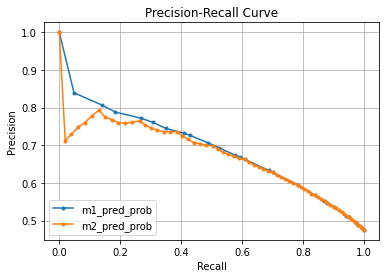

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(df: pd.DataFrame, pred_cols) -> None:
    for pred_col in pred_cols:
        # Compute precision and recall
        precision, recall, thresholds = precision_recall_curve(
            _df["ind_picked"], _df[pred_col]
        )

        # Plot Precision-Recall curve
        plt.plot(recall, precision, marker='.', label=pred_col)  

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.legend(loc="lower left")
    plt.show()

plot_pr_curve(_df, ["m1_pred_prob", "m2_pred_prob"])

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(df: pd.DataFrame, pred_cols) -> None:
    for pred_col in pred_cols:
        # Compute ROC curve and ROC area for each class
        fpr, tpr, thresholds = roc_curve(
            _df["ind_picked"], _df["m1_pred_prob"]
        )
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        # plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkgreen', lw=lw, label='{pred_col} (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curve(_df, ["m1_pred_prob", "m2_pred_prob"])

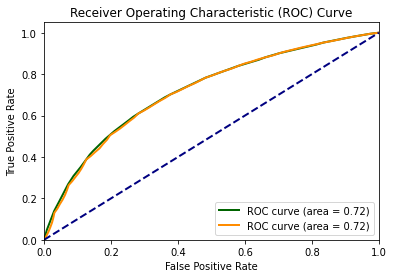

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(
    _df["ind_picked"], _df["m1_pred_prob"]
)
roc_auc = auc(fpr, tpr)

fpr2, tpr2, thresholds2 = roc_curve(
    _df["ind_picked"], _df["m2_pred_prob"]
)
roc_auc2 = auc(fpr2, tpr2)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkgreen', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


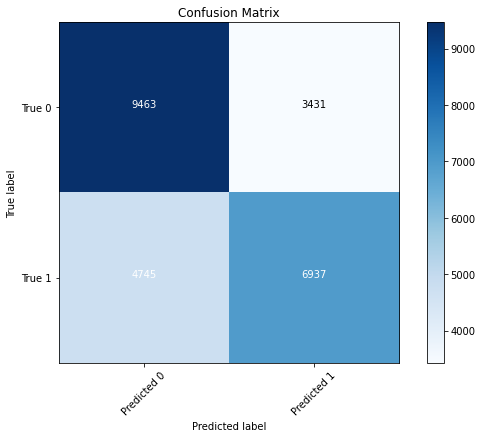

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example ground truth labels and predicted labels
y_true = np.array([0, 1, 1, 0, 1, 1, 0, 0, 1, 0])
y_pred = np.array([0, 1, 1, 0, 1, 0, 1, 0, 1, 0])

# Compute confusion matrix
cm = confusion_matrix(
    _df["ind_picked"], _df["m1_pred"]
)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted 0', 'Predicted 1'], rotation=45)
plt.yticks(tick_marks, ['True 0', 'True 1'])
thresh = cm.max() / 2.
for i, j in ((i, j) for i in range(cm.shape[0]) for j in range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [18]:
from statistics import stdev, mean, variance

a = [1, 1]

stdev(a)
# variance(a)

0.0

In [70]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# mv.model.estimators_[0].tree_
# d_clf = mv.model.estimators_[0]

x_test = df_test[features]
y_test = df_test[target]

d_clf = DecisionTreeClassifier(max_leaf_nodes=100, random_state=0)
d_clf.fit(x_train, y_train)

_y_pred = d_clf.predict(x_test)

_y_pred_prob = d_clf.predict_proba(x_test)
_y_pred_prob = _y_pred_prob[:,1]

loss = brier_score_loss(y_test, _y_pred_prob)

_df_test_w_pred = merge_prediction(df_test, _y_pred, 'pred')
_df_test_w_pred = merge_prediction(_df_test_w_pred, _y_pred, 'pred_prob')

print(loss)


# plot_tree(d_clf)
# plt.show()

0.02570867591043326


13
10


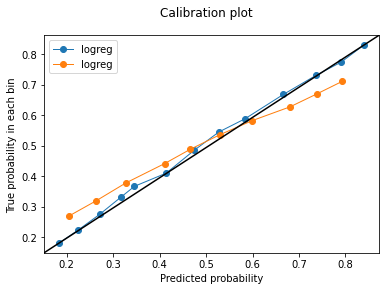

0.2132421624826414 
 0.21628360997805274


In [17]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

_df = df_test_w_pred.loc[
    # (df_test_w_pred['round'] <= 18)

    (df_test_w_pred['diff_cur_rank_picks_btwn'] <= 5) 
    & (df_test_w_pred['diff_cur_rank_picks_btwn'] >= -5)
    & (df_test_w_pred['round'] <= 10)
    & (df_test_w_pred['round'] >= 5)
]
# _df = df_test_w_pred.loc[(df_test_w_pred['diff_cur_rank_picks_btwn'] <= 10)]
# _df = df_test_w_pred.loc[df_test_w_pred['round'] >= 14]
# _df = df_test_w_pred

y_actual = _df[target]
# y_pred = _df['pred_prob']
# y_pred2 = _df["pred_prob"]

y_pred = _df['m1_pred_prob']
y_pred2 = _df["m2_pred_prob"]

actual, pred = calibration_curve(y_actual, y_pred, n_bins=20)
actual2, pred2 = calibration_curve(y_actual, y_pred2, n_bins=20)
# actual, pred = calibration_curve(y_test, y_pred_prob, n_bins=20)
# actual, pred = calibration_curve(y_test_new, y_pred_prob_new, n_bins=20)
# actual, pred = calibration_curve(y_test_filt, y_pred_prob_filt, n_bins=40, strategy='quantile')

print(len(pred))
print(len(pred2))

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(actual, pred, marker='o', linewidth=1, label='logreg')
plt.plot(actual2, pred2, marker='o', linewidth=1, label='logreg')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

# _df["pred_prob"].quantile(0.3)
# loss_v2 = brier_score_loss(_df[target], _df["pred_prob"])
loss_v2 = brier_score_loss(_df[target], _df["m1_pred_prob"])
loss2_v2 = brier_score_loss(_df[target], _df["m2_pred_prob"])
print(loss_v2, "\n", loss2_v2)

# y_pred

In [83]:
_df = df_test_w_pred.copy()
# _df = _df.loc[(_df["round"] == 2)]
_df = _df.loc[(_df["round"] == 3) & (_df["round_pick"] == 1)]
_df.sort_values(by=["draft_id", "round", "round_pick", "avail_cur_rank_actual"], inplace=True)

_df["ind_picked"].sum()
len(_df)
_df.groupby("draft_id").size().to_frame().reset_index()
# _df["round_pick"].drop_duplicates()

,draft_id,0
0,18b7bc6c-edd1-44d9-bb04-2448d0b224da,200
1,2cc3831e-6e95-498c-9bdd-1d3f15cbbc8a,200
2,3351edc3-33f9-4714-b5c1-d4202806c5cc,200
3,37130cef-4e75-4746-81b4-3c1a56b0870a,200
4,3b54e1ef-f16c-473e-867b-c048d59a8e52,200
5,3d1af90a-270f-40be-8fbd-3ef906aa8965,192
6,3e193c4f-25cb-4e57-80f2-df30c0028767,200
7,47fc180e-9169-4fdc-ae96-339abe238fef,192
8,4c80105e-d8d6-414f-88b5-236bb86c1e3f,200
9,674c9996-7c93-47d9-91e3-aa2609866ef9,200


In [ ]:
###############################################################################
################################## SCRATCH ####################################
###############################################################################

In [57]:
_df = df_model.copy()

conds = ((_df['draft_id'] == '133d89ab-ba4f-4230-9148-396bee781f5c')
        & (_df['number'] == 11)
        # & (_df['avail_cur_rank_actual'] == 1)
        # & (_df['draft_entry_id'] == 'c488824b-b11d-42f0-b16c-e59fc361e425')
        )
_df.loc[conds]

,drafted_player_key,avail_player_key,avail_rank_actual,avail_team,avail_position,avail_projection_adp,appearance_id,created_at,draft_entry_id,number,projection_adp,draft_id,draft_source,draft_title,num_teams,round,round_pick,draft_datetime,draft_date,draft_year,ranks_type,drafted_player,drafted_team,drafted_position,ranks_draft_date,avail_number,next_pick_number,ind_avail,avail_cur_rank_actual,picks_btwn,diff_cur_rank_picks_btwn,ind_rank_btwn,ind_picked
4776325,Davante Adams - 2022-05-15 - 9.9,Davante Adams - 2022-05-15 - 9.9,9,LV,WR,9.9,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,11.0,14.0,0,1,3.0,-2.0,1,1
4776326,Davante Adams - 2022-05-15 - 9.9,Joe Mixon - 2022-05-15 - 12.2,12,CIN,RB,12.2,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,12.0,14.0,0,2,3.0,-1.0,1,1
4776327,Davante Adams - 2022-05-15 - 9.9,Travis Kelce - 2022-05-15 - 12.6,13,KC,TE,12.6,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,13.0,14.0,0,3,3.0,0.0,1,1
4776328,Davante Adams - 2022-05-15 - 9.9,CeeDee Lamb - 2022-05-15 - 14.3,14,DAL,WR,14.3,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,14.0,14.0,1,4,3.0,1.0,0,0
4776329,Davante Adams - 2022-05-15 - 9.9,Deebo Samuel - 2022-05-15 - 16.6,15,SF,WR,16.6,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,18.0,14.0,1,5,3.0,2.0,0,0
4776330,Davante Adams - 2022-05-15 - 9.9,Mark Andrews - 2022-05-15 - 17.3,16,BAL,TE,17.3,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,15.0,14.0,1,6,3.0,3.0,0,0
4776331,Davante Adams - 2022-05-15 - 9.9,D'Andre Swift - 2022-05-15 - 17.6,17,DET,RB,17.6,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,16.0,14.0,1,7,3.0,4.0,0,0
4776332,Davante Adams - 2022-05-15 - 9.9,Alvin Kamara - 2022-05-15 - 19.1,18,NO,RB,19.1,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,17.0,14.0,1,8,3.0,5.0,0,0
4776333,Davante Adams - 2022-05-15 - 9.9,Tyreek Hill - 2022-05-15 - 20.1,19,MIA,WR,20.1,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,26.0,14.0,1,9,3.0,6.0,0,0
4776334,Davante Adams - 2022-05-15 - 9.9,Mike Evans - 2022-05-15 - 20.2,20,TB,WR,20.2,afce47e8-89bb-48d5-bc3a-5fc67a0ce50b,2022-05-15 23:11:31,c488824b-b11d-42f0-b16c-e59fc361e425,11,9.9,133d89ab-ba4f-4230-9148-396bee781f5c,sit_and_go,NaN,12,1,11,2022-05-15 23:09:01,2022-05-15,2022,actual,Davante Adams,LV,WR,2022-05-15,20.0,14.0,1,10,3.0,7.0,0,0


In [6]:
_df = df_final.groupby('ind_avail').size().to_frame('num_players').reset_index()
_df['perc_players'] = _df['num_players'] / len(df_final)

_df

,ind_avail,num_players,perc_players
0,0,438328,0.093861
1,1,4231630,0.906139


In [49]:
splitter = GroupShuffleSplit(test_size=0.20, n_splits=10, random_state=7)
split = splitter.split(df, groups=df['draft_id'])
a = [1, 2]

for i, check in enumerate(split):
    if i == 0:
        print(len(check[1]))
    else:
        break

1024242


In [40]:
# _df = df_train.copy()
# _df = _df.groupby(['draft_year'], dropna=False)['draft_id'].nunique().to_frame('num_picks')

num_train = df_train['draft_id'].nunique()
num_test = df_test['draft_id'].nunique()

print(num_train)
print(num_test)
print(num_train + num_test)
print(df_model['draft_id'].nunique())
print(num_train / (num_train + num_test))

124
32
156
156
0.7948717948717948


In [12]:
# accuracy = metrics.accuracy_score(y_test, y_pred)
# accuracy_percentage = 100 * accuracy

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(recall)
print(precision)

0.7931172291296625
0.7931172291296625


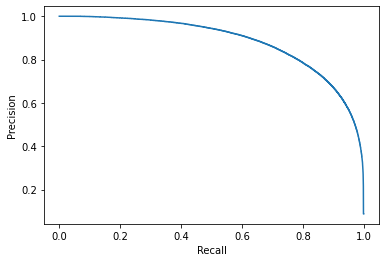

In [23]:
precision, recall, threshold = precision_recall_curve(y_test, 
                                                      y_pred_prob)
prd = PrecisionRecallDisplay(precision, recall)
prd.plot()

In [25]:
# precision[196:]
# recall[197:]
threshold[196:]

array([0.35637088, 0.56847159, 0.60674675, 0.64375449, 0.67912138,
       0.71254498, 0.74380048, 0.77274141, 0.79929527, 0.82345531,
       0.84527006, 0.86483174, 0.8822648 , 0.89771539, 0.91134213,
       0.92330855, 0.93377719, 0.94290519, 0.95084124, 0.95772366,
       0.96367933, 0.9688233 , 0.97325896, 0.97707847, 0.98036344])

In [11]:
_df = df_train.copy()
_df = _df.groupby(['draft_year'], dropna=False)['draft_id'].nunique().to_frame('num_picks')

_df

,num_picks
draft_year,
2021,88
2022,36
